In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('/Users/Masih/Desktop/bootcamp /Euro-USD-Prediction-/eur_usd_lstm_model.h5')


2024-05-23 20:32:45.966040: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[*********************100%%**********************]  1 of 1 completed


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step


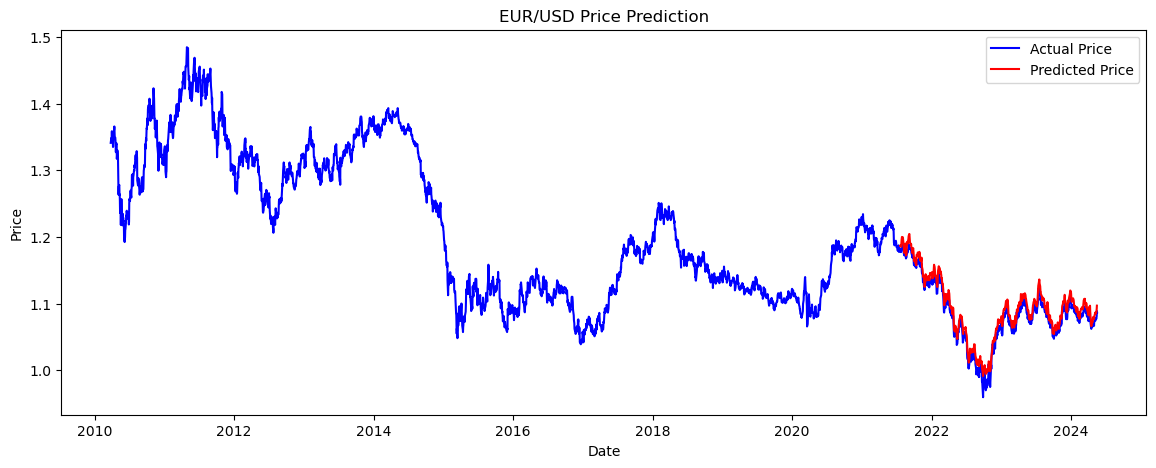

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━

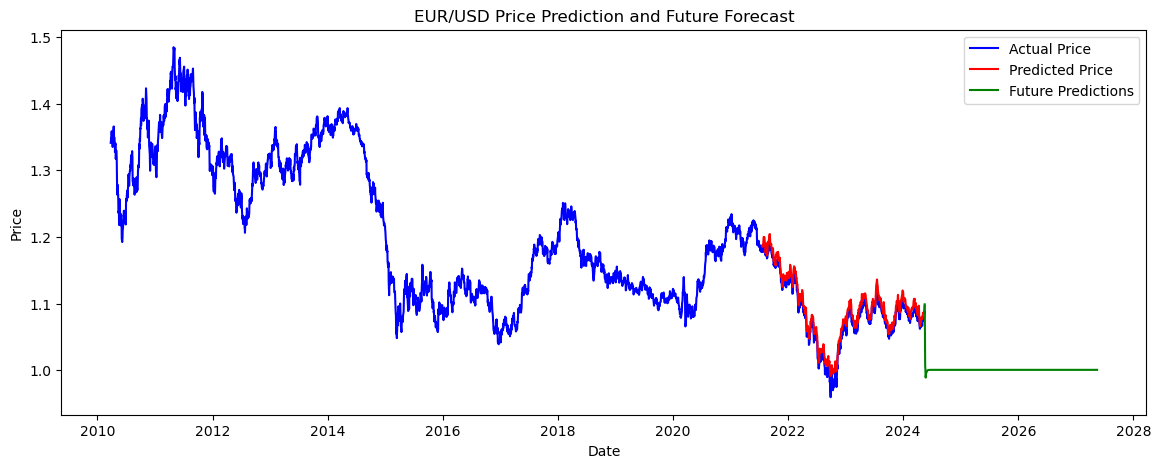

In [2]:


# Load and preprocess data (same steps as before to ensure consistency)
ticker = 'EURUSD=X'
data = yf.download(ticker, start='2010-01-01', end='2024-05-20')
data2 = data.copy()
data2.dropna(inplace=True)

from ta import add_all_ta_features
from ta.utils import dropna

data2 = add_all_ta_features(
    data2, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
)
data2.dropna(inplace=True)
data2['Return'] = data2['Close'].pct_change()
data2.dropna(inplace=True)

features = ['Close', 'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volatility_bbm',
            'volatility_bbh', 'volatility_bbl', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
            'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_ema_fast', 'trend_ema_slow',
            'momentum_rsi', 'momentum_stoch_rsi']

data2 = data2[features]

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data2)

sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i])
    y.append(data_scaled[i, 0])
X, y = np.array(X), np.array(y)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Predict and visualize
predictions = model.predict(X_test)

# We only need to inverse transform the 'Close' predictions, not all features
close_scaler = MinMaxScaler()
close_scaler.fit(data2[['Close']])
predictions = close_scaler.inverse_transform(predictions)

# Adjust indices for plotting
train_data_len = split + sequence_length
test_data_index = data.index[train_data_len:train_data_len + len(predictions)]

plt.figure(figsize=(14, 5))
plt.plot(data.index[sequence_length:], data['Close'][sequence_length:], color='blue', label='Actual Price')
plt.plot(test_data_index, predictions, color='red', label='Predicted Price')
plt.title('EUR/USD Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Predict future values until 2027
future_dates = pd.date_range(start=data.index[-1], periods=365 * 3, freq='D')  # Three years of daily data
future_predictions = []

# Start with the last sequence of the training data
last_sequence = data_scaled[-sequence_length:]

for _ in range(len(future_dates)):
    next_pred = model.predict(last_sequence.reshape(1, sequence_length, data_scaled.shape[1]))
    future_predictions.append(next_pred[0, 0])
    next_pred_expanded = np.zeros((1, data_scaled.shape[1]))  # Create an array of zeros with the same number of features
    next_pred_expanded[0, 0] = next_pred  # Assign the predicted close price to the correct position
    last_sequence = np.append(last_sequence[1:], next_pred_expanded, axis=0)

# Inverse transform the future predictions
future_predictions = close_scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot historical and future predictions
plt.figure(figsize=(14, 5))
plt.plot(data.index[sequence_length:], data['Close'][sequence_length:], color='blue', label='Actual Price')
plt.plot(test_data_index, predictions, color='red', label='Predicted Price')
plt.plot(future_dates, future_predictions, color='green', label='Future Predictions')
plt.title('EUR/USD Price Prediction and Future Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


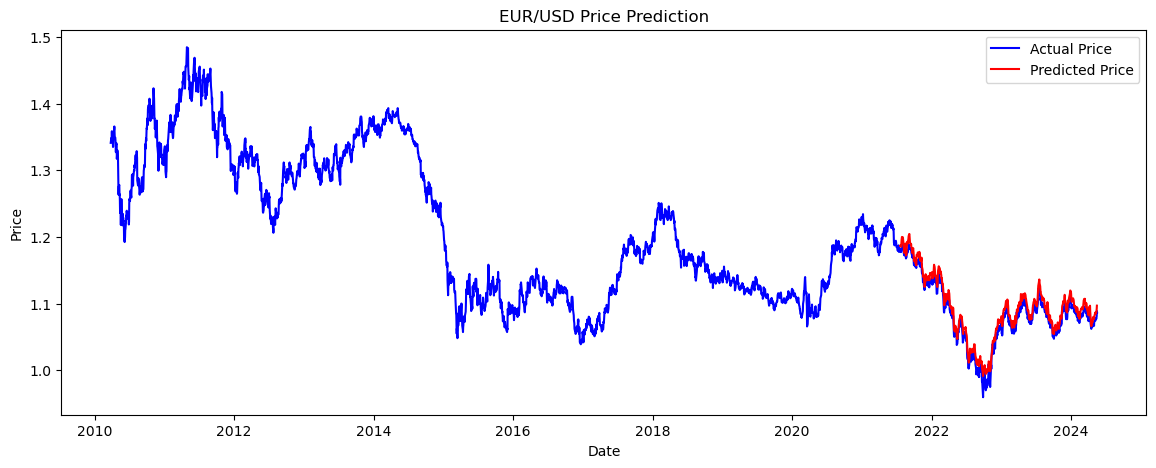

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

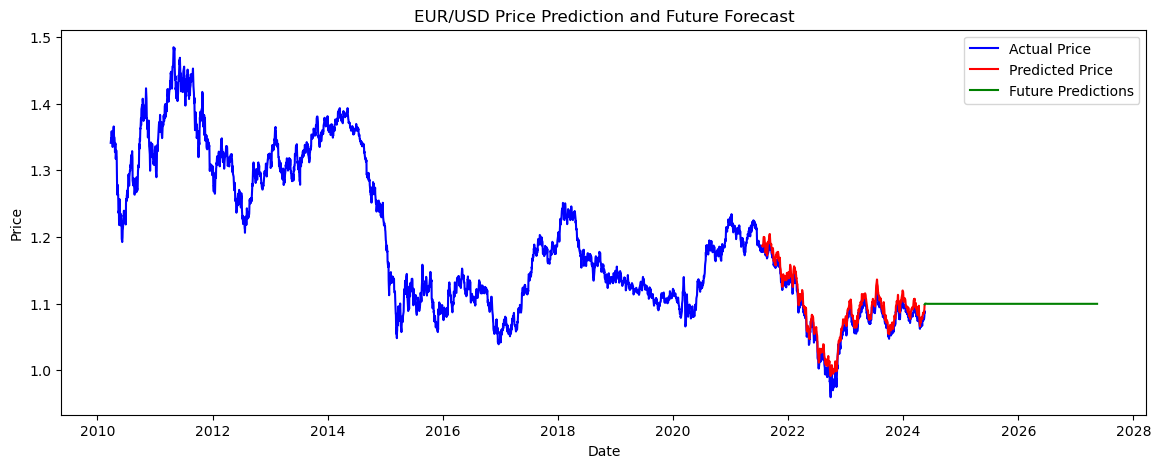

In [5]:


# Load and preprocess data (same steps as before to ensure consistency)
ticker = 'EURUSD=X'
data = yf.download(ticker, start='2010-01-01', end='2024-05-20')
data2 = data.copy()
data2.dropna(inplace=True)

from ta import add_all_ta_features
from ta.utils import dropna

data2 = add_all_ta_features(
    data2, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
)
data2.dropna(inplace=True)
data2['Return'] = data2['Close'].pct_change()
data2.dropna(inplace=True)

features = ['Close', 'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volatility_bbm',
            'volatility_bbh', 'volatility_bbl', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
            'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_ema_fast', 'trend_ema_slow',
            'momentum_rsi', 'momentum_stoch_rsi']

data2 = data2[features]

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data2)

sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i])
    y.append(data_scaled[i, 0])
X, y = np.array(X), np.array(y)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Predict and visualize
predictions = model.predict(X_test)

# We only need to inverse transform the 'Close' predictions, not all features
close_scaler = MinMaxScaler()
close_scaler.fit(data2[['Close']])
predictions = close_scaler.inverse_transform(predictions)

# Adjust indices for plotting
train_data_len = split + sequence_length
test_data_index = data.index[train_data_len:train_data_len + len(predictions)]

plt.figure(figsize=(14, 5))
plt.plot(data.index[sequence_length:], data['Close'][sequence_length:], color='blue', label='Actual Price')
plt.plot(test_data_index, predictions, color='red', label='Predicted Price')
plt.title('EUR/USD Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Predict future values until 2027
future_dates = pd.date_range(start=data.index[-1], periods=365 * 3, freq='D')  # Three years of daily data
future_predictions = []

# Start with the last sequence of the training data
last_sequence = data_scaled[-sequence_length:]

for _ in range(len(future_dates)):
    next_pred = model.predict(last_sequence.reshape(1, sequence_length, data_scaled.shape[1]))
    future_predictions.append(next_pred[0, 0])
    next_pred_expanded = np.array(last_sequence[-1])
    next_pred_expanded[0] = next_pred  # Assign the predicted close price to the correct position
    last_sequence = np.append(last_sequence[1:], next_pred_expanded.reshape(1, -1), axis=0)

# Inverse transform the future predictions
future_predictions = close_scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot historical and future predictions
plt.figure(figsize=(14, 5))
plt.plot(data.index[sequence_length:], data['Close'][sequence_length:], color='blue', label='Actual Price')
plt.plot(test_data_index, predictions, color='red', label='Predicted Price')
plt.plot(future_dates, future_predictions, color='green', label='Future Predictions')
plt.title('EUR/USD Price Prediction and Future Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
